<a href="https://colab.research.google.com/github/kooose38/create_model/blob/dev/CNN_img_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch, torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import pytorch_lightning as pl  
import optuna 
from pytorch_lightning.metrics.functional import accuracy 
from pytorch_lightning.callbacks import EarlyStopping 
from torchvision import transforms 
from torchvision.datasets import CIFAR10

In [6]:
#画像変換処理はランダムに選ばれる
trans = transforms.Compose([
                            transforms.RandomHorizontalFlip(),  #水平移動
                            transforms.RandomVerticalFlip(), #水平反転
                            transforms.ToTensor()

])

train_val = CIFAR10(root='.', train=True, download=True, transform=trans)
test = CIFAR10(root='.', train=False, download=True, transform=trans)
len(train_val), len(test)


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


(50000, 10000)

In [7]:
n_train = int(len(train_val)*0.8)
n_val = len(train_val) - n_train

torch.manual_seed(0)
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

batch = 216
train_loader = torch.utils.data.DataLoader(train, batch_size=batch, drop_last=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch, drop_last=True, shuffle=True)

len(train_loader)

185

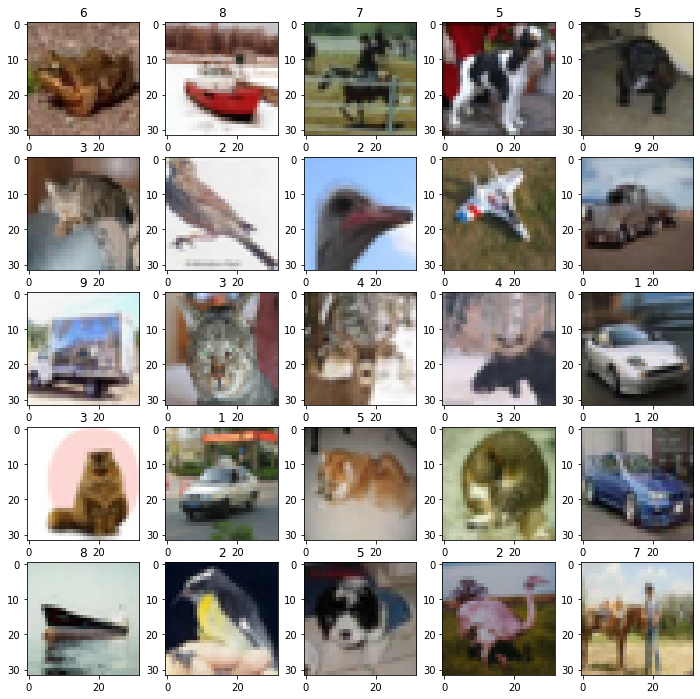

In [8]:
fig, axes = plt.subplots(5,5,figsize=(12,12))
ax = axes.ravel()

for i in range(25):
  img = train[i][0]
  img = np.transpose(img, (1,2,0))
  label = train[i][1]

  ax[i].imshow(img)
  ax[i].set_title(label)

plt.show()

In [19]:
sample_data = train[0][0].reshape(1,3,32,32)
sample_data.shape

torch.Size([1, 3, 32, 32])

In [49]:
class Net(pl.LightningModule):
  def __init__(self, lr):
    super().__init__()
    self.lr = lr
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 216, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(216, 512, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(512*2*2,512)
    self.fc2 = nn.Linear(512, 10)

    self.bt1 = nn.BatchNorm2d(64)
    self.bt2 = nn.BatchNorm2d(128)
    self.bt3 = nn.BatchNorm2d(216)
    self.bt4 = nn.BatchNorm2d(512)

    self.drop = nn.Dropout2d(p=0.5)

  def forward(self, h):
    h = self.conv1(h)
    h = self.bt1(h)
    h = F.relu(h)
    h = F.max_pool2d(h, kernel_size=2, stride=2)
    
    h = self.conv2(h)
    h = self.bt2(h)
    h = F.relu(h)
    h = F.max_pool2d(h, kernel_size=2, stride=2)

    h = self.conv3(h)
    h = self.bt3(h)
    h = F.relu(h)
    h = F.max_pool2d(h, kernel_size=2, stride=2)

    h = self.conv4(h)
    h = self.bt4(h)
    h = F.relu(h)
    h = F.max_pool2d(h, kernel_size=2, stride=2)

    h = h.view(-1, 512*2*2)
    h = self.drop(h)
    h = self.fc1(h)
    h = F.relu(h)
    h = self.fc2(h)
    h = F.softmax(h)
    return h

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self.forward(x)
    loss = F.cross_entropy(y, t)
    return loss

  def validation_step(self, batch, batch_idx):
    x, t = batch
    y = self.forward(x)
    loss = F.cross_entropy(y, t)
    acc = accuracy(y, t)
    self.log('val_acc', acc, on_step=True)
    self.log('val_loss', loss, on_step=True)
    return loss

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self.forward(x)
    loss = F.cross_entropy(y, t)
    acc = accuracy(y, t)
    self.log('test_acc', acc, on_step=True)
    self.log('test_acc', acc, on_step=True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
    return optimizer

In [46]:
net = Net()
pl.seed_everything(0)
trainer = pl.Trainer(max_epochs=10, deterministic=True, gpus=1, callbacks=[EarlyStopping(monitor='val_acc')])
trainer.fit(net, train_loader, val_loader)

Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



1

In [47]:
trainer.test(test_dataloaders=test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

you passed in a test_dataloader but have no test_step. Skipping test loop



1

In [48]:
trainer.callback_metrics

{'test_acc': tensor(0.0694, device='cuda:0'),
 'val_acc': tensor(0.0833, device='cuda:0'),
 'val_acc_epoch': tensor(0.0990, device='cuda:0'),
 'val_loss': tensor(2.3025, device='cuda:0'),
 'val_loss_epoch': tensor(2.3005, device='cuda:0')}

In [53]:
def objctive(trial):
  lr = trial.suggest_loguniform('lr', 1e-5,1e-1)

  net = Net(lr=lr)
  pl.seed_everything(0)
  trainer = pl.Trainer(max_epochs=10, gpus=1, deterministic=True, callbacks=[EarlyStopping(monitor='val_acc')])
  trainer.fit(net, train_loader, val_loader)
  return trainer.callback_metrics['val_acc']

In [54]:
sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objctive, n_trials=20)

[I 2021-03-20 10:19:36,247] A new study created in memory with name: no-name-8e8c0e62-c532-4373-b32f-f50c8c0f81ef
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Your val_dataloader has `shuffle=True`, it is best practice to turn this o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



[I 2021-03-20 10:21:17,870] Trial 0 finished with value: 0.31481480598449707 and parameters: {'lr': 0.0015676677195506068}. Best is trial 0 with value: 0.31481480598449707.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


[I 2021-03-20 10:23:00,697] Trial 1 finished with value: 0.49074074625968933 and parameters: {'lr': 0.007257005721594277}. Best is trial 1 with value: 0.49074074625968933.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


[I 2021-03-20 10:24:44,861] Trial 2 finished with value: 0.35648149251937866 and parameters: {'lr': 0.0025766385746135885}. Best is trial 1 with value: 0.49074074625968933.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


[I 2021-03-20 10:25:26,830] Trial 3 finished with value: 0.13425925374031067 and parameters: {'lr': 0.0015119336467641006}. Best is trial 1 with value: 0.49074074625968933.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


[I 2021-03-20 10:27:10,587] Trial 4 finished with value: 0.17592592537403107 and parameters: {'lr': 0.0004950159553733195}. Best is trial 1 with value: 0.49074074625968933.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


[I 2021-03-20 10:28:54,064] Trial 5 finished with value: 0.43981480598449707 and parameters: {'lr': 0.0038333321561566623}. Best is trial 1 with value: 0.49074074625968933.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


[I 2021-03-20 10:30:36,816] Trial 6 finished with value: 0.20370370149612427 and parameters: {'lr': 0.0005627932047415167}. Best is trial 1 with value: 0.49074074625968933.
Global seed set to 0
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 1.8 K 
1  | conv2 | Conv2d      | 73.9 K
2  | conv3 | Conv2d      | 249 K 
3  | conv4 | Conv2d      | 995 K 
4  | fc1   | Linear      | 1.0 M 
5  | fc2   | Linear      | 5.1 K 
6  | bt1   | BatchNorm2d | 128   
7  | bt2   | BatchNorm2d | 256   
8  | bt3   | BatchNorm2d | 432   
9  | bt4   | BatchNorm2d | 1.0 K 
10 | drop  | Dropout2d   | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.506     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

[W 2021-03-20 10:30:43,346] Trial 7 failed because of the following error: KeyError('val_acc')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-53-ffe0175159e4>", line 8, in objctive
    return trainer.callback_metrics['val_acc']
KeyError: 'val_acc'


KeyError: ignored

In [56]:
torch.save(net.state_dict(), 'pl.pt')

In [67]:
net = Net(lr=1e-1)
pl.seed_everything(0)
net.load_state_dict(torch.load('pl.pt'))
pred = net.forward(sample_data)
torch.argmax(pred), train[0][1]

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



(tensor(1), 6)

# 画像処理
少ない特長量の中でも、画像変換することで差異を増やし学習率を向上させる狙い。

In [74]:
img = train[100][0]

ToPIL = transforms.ToPILImage()
img = ToPIL(img)

In [75]:
def show(before_img, after_img):
  fig, axes = plt.subplots(1,2,figsize=(15,10))
  ax = axes.flatten()

  ax[0].imshow(before_img)
  ax[0].set_title('before')
  ax[1].imshow(after_img)
  ax[1].set_title('after')
  plt.show()

# 回転

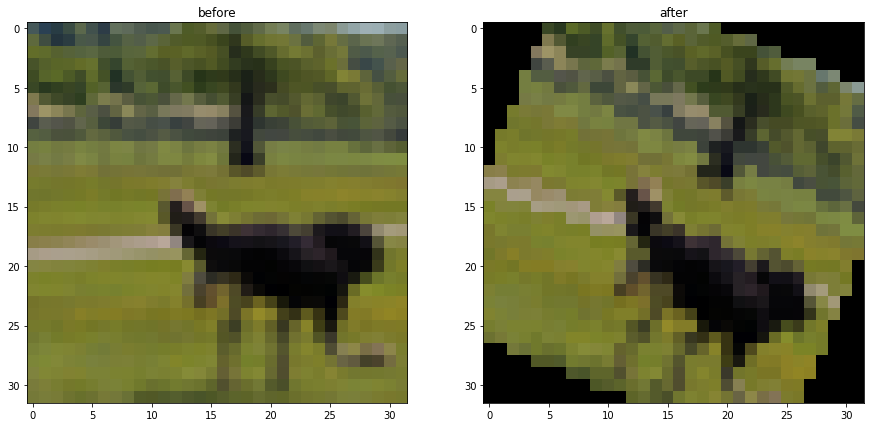

In [76]:
transform = transforms.RandomRotation(degrees=30)
out = transform(img)

show(img, out)

# 水平移動
ランダムに縦横に移動する

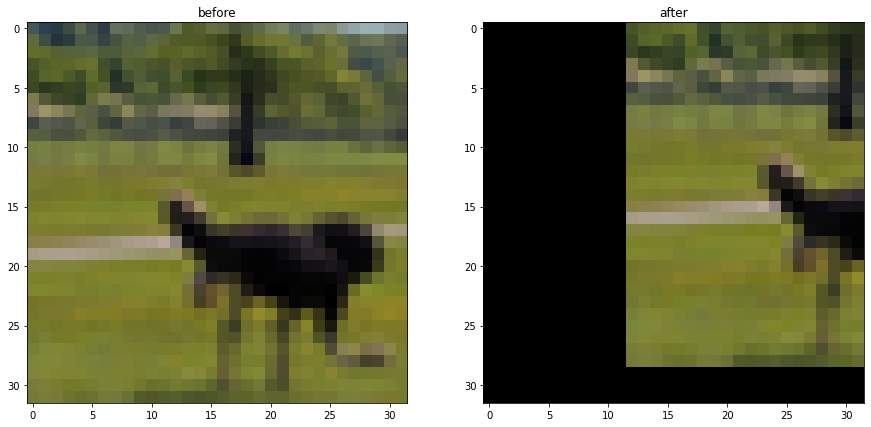

In [83]:
transform = transforms.RandomAffine(degrees=0, translate=(0.5, 0.5))
out = transform(img)

show(img, out)

# せん断

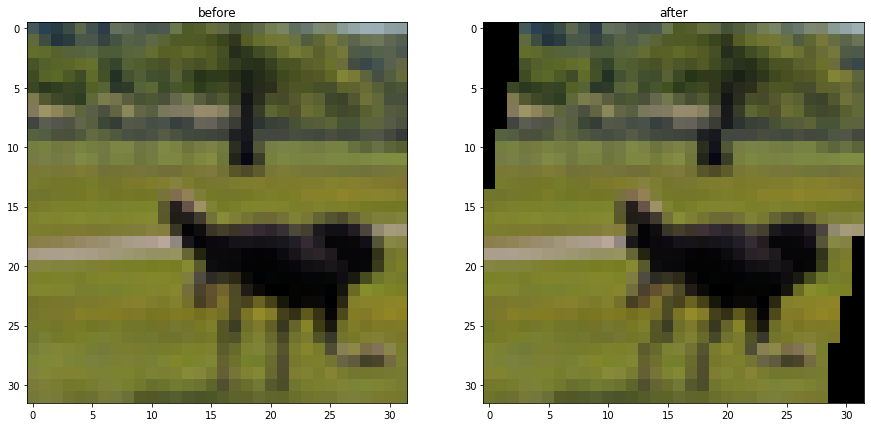

In [86]:
transform = transforms.RandomAffine(degrees=0, translate=(0, 0), shear=(0, 60))
out = transform(img)

show(img, out)

# 拡大

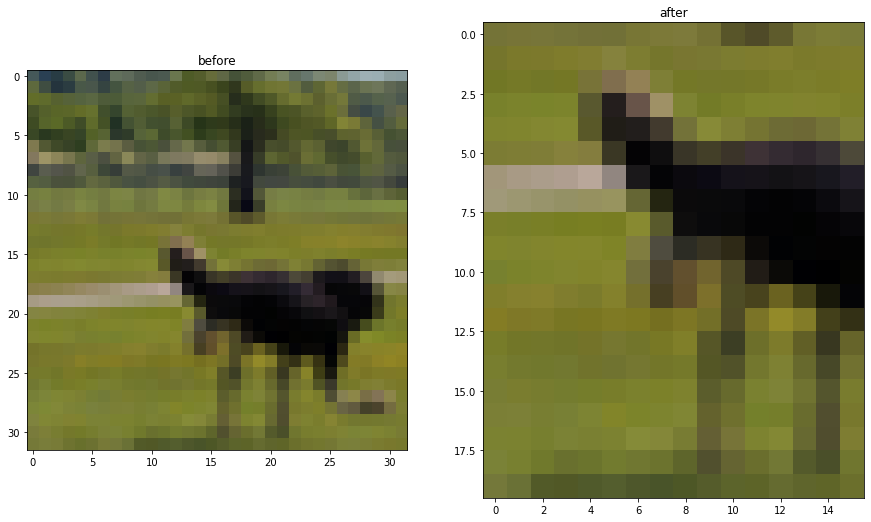

In [88]:
transform = transforms.RandomCrop((20,16))
out = transform(img)

show(img, out)

# 反転

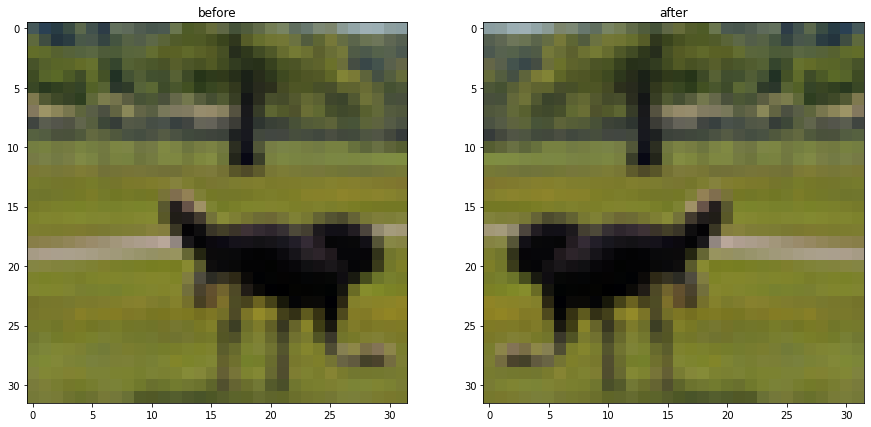

In [89]:
transform = transforms.RandomHorizontalFlip(p=1)
out = transform(img)

show(img, out)

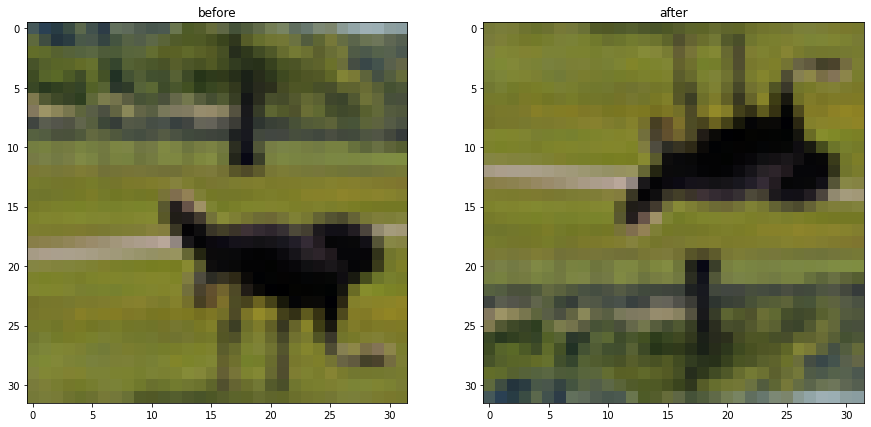

In [90]:
transform = transforms.RandomVerticalFlip(p=1)
out = transform(img)

show(img, out)

# 空白箇所の塗りつぶし
RGBの精度をタプルで与える

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning:

Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead



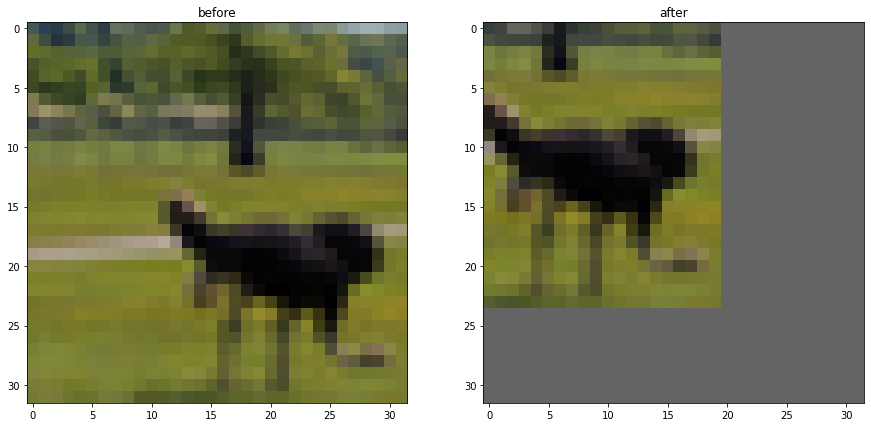

In [91]:
transform = transforms.RandomAffine(degrees=0, translate=(0.5, 0.5), fillcolor=(100,100,100))
out = transform(img)

show(img, out)

変換後の写真を保存する

In [92]:
out.save('out.jpg')